(tax_smoothing_2)=
```{raw} html
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

```{index} single: python
```

# How to Pay for a War: Part 2

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture  deploys the quantecon library:

In [1]:
!pip install --upgrade quantecon

## An Application of Markov Jump Linear Quadratic Dynamic Programming

This is a {doc}`sequel to an earlier lecture <tax_smoothing_1>`.

We use a method introduced in lecture {doc}`Markov Jump LQ dynamic programming <markov_jump_lq>` to
implement suggestions by Barro (1999 {cite}`barro1999determinants`, 2003 {cite}`barro2003religion`) for extending his
classic 1979 model of tax smoothing.

Barro’s 1979 {cite}`Barro1979` model is about a government that borrows and lends in order
to help it minimize an intertemporal measure of distortions caused by
taxes.

Technically, Barro’s 1979 {cite}`Barro1979` model looks a lot like a consumption-smoothing model.

Our generalizations of his 1979 {cite}`Barro1979` model will also look
like souped-up consumption-smoothing models.

Wanting tractability induced Barro in 1979 {cite}`Barro1979` to assume that

- the government trades only one-period risk-free debt, and
- the one-period risk-free interest rate is constant

In our {doc}`earlier lecture <tax_smoothing_1>`, we relaxed the second of these assumptions but not the first.

In particular, we used *Markov jump linear quadratic dynamic programming*
to allow the exogenous interest rate to vary over time.

In this lecture, we add a maturity composition decision to the
government’s problem by expanding the dimension of the state.

We assume

- that the government borrows or saves in the form of risk-free bonds
  of maturities $1, 2, \ldots , H$.
- that interest rates on those bonds are time-varying and in particular are
  governed by a jointly stationary stochastic process.

Let's start with some standard imports:

In [2]:
import quantecon as qe
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Two example specifications

We’ll describe two possible specifications

- In one, each period the government issues zero-coupon
  bonds of one- and two-period maturities and redeems them only when
  they mature -- in this version, the maturity structure of government
  debt at each date is partly inherited from the past.
- In the second, the government redesigns the maturity
  structure of the debt each period.

## One- and Two-period Bonds but No Restructuring

Let $T_t$ denote tax collections, $\beta$ a discount factor,
$b_{t,t+1}$ time $t+1$ goods that the government promises to
pay at $t$, $b_{t,t+2}$ time $t+2$ goods that the
government promises to pay at time $t$, $G_t$ government
purchases, $p_{t,t+1}$ the number of time $t$ goods received
per time $t+1$ goods promised, and $p_{t,t+2}$ the number of
time $t$ goods received per time $t+2$ goods promised.

Evidently, $p_{t, t+1}, p_{t,t+2}$ are inversely related to
appropriate corresponding gross interest rates on government debt.

In the spirit of Barro (1979) {cite}`Barro1979`, government
expenditures are governed by an exogenous stochastic process.

Given initial conditions $b_{-2,0}, b_{-1,0}, z_0, i_0$, where
$i_0$ is the initial Markov state, the government chooses a
contingency plan for $\{b_{t, t+1}, b_{t,t+2}, T_t\}_{t=0}^\infty$
to maximize.

$$
- E_0 \sum_{t=0}^\infty \beta^t \left[ T_t^2 + c_1( b_{t,t+1} - b_{t,t+2})^2 \right]
$$

subject to the constraints

$$
\begin{aligned}
T_t & = G_t + b_{t-2,t} + b_{t-1,t} - p_{t,t+2} b_{t,t+2} - p_{t,t+1} b_{t,t+1} \cr
  G_t &  = U_{g,s_t} z_t \cr
  z_{t+1} & = A_{22,s_t} z_t + C_{2,s_t} w_{t+1} \cr
  \begin{bmatrix}
   p_{t,t+1} \cr
   p_{t,t+2} \cr
   U_{g,s_t} \cr
   A_{22,s_t} \cr
   C_{2,s_t}
  \end{bmatrix} & \sim \textrm{functions of Markov state with transition matrix } \Pi \end{aligned}
$$

Here $w_{t+1} \sim {\cal N}(0,I)$ and $\Pi_{ij}$ is
the probability that the Markov state moves from state $i$ to
state $j$ in one period.

The variables
$T_t, b_{t, t+1}, b_{t,t+2}$ are *control* variables chosen at
$t$, while the variables $b_{t-1,t}, b_{t-2,t}$ are
endogenous state variables inherited from the past at time $t$ and
$p_{t,t+1}, p_{t,t+2}$ are exogenous state variables at time
$t$.

The parameter $c_1$ imposes a penalty on the government’s issuing
different quantities of one and two-period debt.

This penalty deters the
government from taking large “long-short” positions in debt of different
maturities. An example below will show this in action.

As well as extending the model to allow for a maturity decision for
government debt, we can also in principle allow the matrices
$U_{g,s_t}, A_{22,s_t}, C_{2,s_t}$ to depend on the Markov state $s_t$.

Below, we will often adopt the convention that for matrices appearing in a linear state space,
$A_t \equiv A_{s_t}, C_t \equiv C_{s_t}$ and so on, so that dependence on $t$ is always
intermediated through the Markov state $s_t$.

## Mapping into an LQ Markov Jump Problem

First, define

$$
\hat b_t = b_{t-1,t} + b_{t-2,t} ,
$$

which is debt due at time $t$.

Then define the endogenous part of the state:

$$
\bar b_t = \begin{bmatrix}
 \hat b_t \cr
   b_{t-1,t+1}
\end{bmatrix}
$$

and the complete state

$$
x_t = \begin{bmatrix} \bar b_t \cr
        z_t
      \end{bmatrix}
$$

and the control vector

$$
u_{t} =  \begin{bmatrix}
   b_{t,t+1} \cr
   b_{t,t+2}
  \end{bmatrix}
$$

The endogenous part of state vector follows the law of motion:

$$
\begin{bmatrix}
    \hat b_{t+1} \cr
    b_{t,t+2}
   \end{bmatrix}
   =
   \begin{bmatrix}
    0 & 1 \cr
    0 & 0
   \end{bmatrix}
 \begin{bmatrix}
  \hat b_{t} \cr
  b_{t-1,t+1}
 \end{bmatrix}
+
  \begin{bmatrix}
   1 & 0 \cr
   0 & 1 \cr
  \end{bmatrix}
   \begin{bmatrix}
    b_{t,t+1} \cr
    b_{t,t+2}
   \end{bmatrix}
$$

or

$$
\bar b_{t+1} = A_{11} \bar b_t + B_1 u_t
$$

Define the following functions of the state

$$
G_t = S_{G,t} x_t, \quad \hat b_t = S_1 x_t
$$

and

$$
M_t  =  \begin{bmatrix} - p_{t,t+1} & - p_{t,t+2} \end{bmatrix}
$$

where $p_{t,t+1}$ is the discount on one period loans in the
discrete Markov state at time $t$ and $p_{t,t+2}$ is the
discount on two-period loans in the discrete Markov state.

Define

$$
S_t = S_{G,t} + S_1
$$

Note that in discrete Markov state $i$

$$
T_t = M_t u_t + S_t x_t
$$

It follows that

$$
T_t^2 = x_t' S_t' S_t x_t + u_t' M_t' M_t u_t + 2 u_t' M_t' S_t x_t
$$

or

$$
T_t^2 = x_t'R_t x_t + u_t' Q_t u_t + 2 u_t' W_t x_t
$$

where

$$
R_t = S_t'S_t, \quad Q_t = M_t' M_t, \quad  W_t = M_t' S_t
$$

Because the payoff function also includes the penalty parameter on
issuing debt of different maturities, we have:

$$
T_t^2 + c_1( b_{t,t+1} - b_{t,t+2})^2 = x_t'R_t x_t + u_t' Q_t u_t + 2 u_t' W_t x_t +  c_1 u_t'Q^c u_t
$$

where $Q^c = \begin{bmatrix} 1 & -1 \\ -1 & 1 \end{bmatrix}$. Therefore, the overall $Q$ matrix for the Markov jump LQ problem is:

$$
Q_t^c = Q_t + c_1Q^c
$$

The law of motion of the state in all discrete Markov states $i$
is

$$
x_{t+1} = A_t x_t +  B u_t +  C_t w_{t+1}
$$

where

$$
A_t = \begin{bmatrix}  A_{11} & 0 \cr
                        0 & A_{22,t}
      \end{bmatrix}, \quad
       B = \begin{bmatrix}
                  B_1 \cr
                  0
                 \end{bmatrix}, \quad
        C_t = \begin{bmatrix} 0 \cr C_{2,t} \end{bmatrix}
$$

Thus, in this problem all the matrices apart from $B$ may depend
on the Markov state at time $t$.

As shown in the {doc}`previous lecture <tax_smoothing_1>`,
the `LQMarkov` class can solve Markov jump LQ problems when provided with the
$A, B, C, R, Q, W$ matrices for each Markov state.

The function below maps the primitive matrices and parameters from the above
two-period model into the matrices that the `LQMarkov` class requires:

In [3]:
def LQ_markov_mapping(A22, C2, Ug, p1, p2, c1=0):

    """
    Function which takes A22, C2, Ug, p_{t, t+1}, p_{t, t+2} and penalty
    parameter c1, and returns the required matrices for the LQMarkov
    model: A, B, C, R, Q, W.
    This version uses the condensed version of the endogenous state.
    """

    # Make sure all matrices can be treated as 2D arrays
    A22 = np.atleast_2d(A22)
    C2 = np.atleast_2d(C2)
    Ug = np.atleast_2d(Ug)
    p1 = np.atleast_2d(p1)
    p2 = np.atleast_2d(p2)

    # Find the number of states (z) and shocks (w)
    nz, nw = C2.shape

    # Create A11, B1, S1, S2, Sg, S matrices
    A11 = np.zeros((2, 2))
    A11[0, 1] = 1

    B1 = np.eye(2)

    S1 = np.hstack((np.eye(1), np.zeros((1, nz+1))))
    Sg = np.hstack((np.zeros((1, 2)), Ug))
    S = S1 + Sg

    # Create M matrix
    M = np.hstack((-p1, -p2))

    # Create A, B, C matrices
    A_T = np.hstack((A11, np.zeros((2, nz))))
    A_B = np.hstack((np.zeros((nz, 2)), A22))
    A = np.vstack((A_T, A_B))

    B = np.vstack((B1, np.zeros((nz, 2))))

    C = np.vstack((np.zeros((2, nw)), C2))

    # Create Q^c matrix
    Qc = np.array([[1, -1], [-1, 1]])

    # Create R, Q, W matrices

    R = S.T @ S
    Q = M.T @ M + c1 * Qc
    W = M.T @ S

    return A, B, C, R, Q, W

With the above function, we can proceed to solve the model in two steps:

1. Use `LQ_markov_mapping` to map
   $U_{g,t}, A_{22,t}, C_{2,t}, p_{t,t+1}, p_{t,t+2}$ into the
   $A, B, C, R, Q, W$ matrices for each of the $n$ Markov states.
1. Use the `LQMarkov` class to solve the resulting n-state Markov
   jump LQ problem.

## Penalty on Different Issuance Across Maturities

To implement a simple example of the two-period model, we assume that
$G_t$ follows an AR(1) process:

$$
G_{t+1} = \bar G + \rho G_t + \sigma w_{t+1}
$$

To do this, we set $z_t = \begin{bmatrix} 1 \\ G_t \end{bmatrix}$,
and consequently:

$$
A_{22} = \begin{bmatrix} 1 & 0 \\ \bar G & \rho \end{bmatrix} \hspace{2mm} , \hspace{2mm} C_2 = \begin{bmatrix} 0 \\ \sigma \end{bmatrix} \hspace{2mm} , \hspace{2mm} U_g = \begin{bmatrix} 0 & 1 \end{bmatrix}
$$

Therefore, in this example, $A_{22}, C_2$ and $U_g$ are not
time-varying.

We will assume that there are two Markov states, one with a
flatter yield curve, and one with a steeper yield curve. In state 1,
prices are:

$$
p^1_{t,t+1} = \beta \hspace{2mm} , \hspace{2mm} p^1_{t,t+2} = \beta^2 - 0.02
$$

and in state 2, prices are:

$$
p^2_{t,t+1} = \beta \hspace{2mm} , \hspace{2mm}  p^2_{t,t+2} = \beta^2 + 0.02
$$

We first solve the model with no penalty parameter on different issuance
across maturities, i.e. $c_1 = 0$.

We also need to specify a
transition matrix for the Markov state, we use:

$$
\Pi = \begin{bmatrix} 0.9 & 0.1 \\ 0.1 & 0.9 \end{bmatrix}
$$

Thus, each Markov state is persistent, and there is an equal chance of
moving from one to the other.

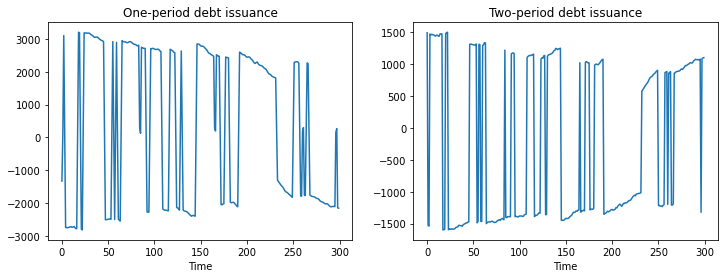

In [4]:
# Model parameters
β, Gbar, ρ, σ, c1 = 0.95, 5, 0.8, 1, 0
p1, p2, p3, p4 = β, β**2 - 0.02, β, β**2 + 0.02

# Basic model matrices
A22 = np.array([[1, 0], [Gbar, ρ] ,])
C_2 = np.array([[0], [σ]])
Ug = np.array([[0, 1]])

A1, B1, C1, R1, Q1, W1 = LQ_markov_mapping(A22, C_2, Ug, p1, p2, c1)
A2, B2, C2, R2, Q2, W2 = LQ_markov_mapping(A22, C_2, Ug, p3, p4, c1)

# Small penalties on debt required to implement no-Ponzi scheme
R1[0, 0] = R1[0, 0] + 1e-9
R2[0, 0] = R2[0, 0] + 1e-9

# Construct lists of matrices correspond to each state
As = [A1, A2]
Bs = [B1, B2]
Cs = [C1, C2]
Rs = [R1, R2]
Qs = [Q1, Q2]
Ws = [W1, W2]

Π = np.array([[0.9, 0.1],
              [0.1, 0.9]])

# Construct and solve the model using the LQMarkov class
lqm = qe.LQMarkov(Π, Qs, Rs, As, Bs, Cs=Cs, Ns=Ws, beta=β)
lqm.stationary_values()

# Simulate the model
x0 = np.array([[100, 50, 1, 10]])
x, u, w, t = lqm.compute_sequence(x0, ts_length=300)

# Plot of one and two-period debt issuance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(u[0, :])
ax1.set_title('One-period debt issuance')
ax1.set_xlabel('Time')
ax2.plot(u[1, :])
ax2.set_title('Two-period debt issuance')
ax2.set_xlabel('Time')
plt.show()

The above simulations show that when no penalty is imposed on different
issuances across maturities, the government has an incentive to take
large “long-short” positions in debt of different maturities.

To prevent such an outcome, we now set $c_1 = 0.01$.

This penalty is enough
to ensure that the government issues positive quantities of both one and
two-period debt:

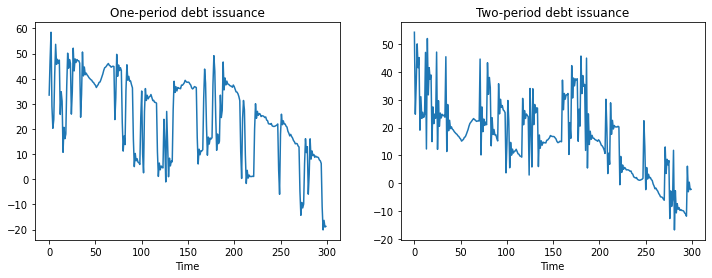

In [5]:
# Put small penalty on different issuance across maturities
c1 = 0.01

A1, B1, C1, R1, Q1, W1 = LQ_markov_mapping(A22, C_2, Ug, p1, p2, c1)
A2, B2, C2, R2, Q2, W2 = LQ_markov_mapping(A22, C_2, Ug, p3, p4, c1)

# Small penalties on debt required to implement no-Ponzi scheme
R1[0, 0] = R1[0, 0] + 1e-9
R2[0, 0] = R2[0, 0] + 1e-9

# Construct lists of matrices
As = [A1, A2]
Bs = [B1, B2]
Cs = [C1, C2]
Rs = [R1, R2]
Qs = [Q1, Q2]
Ws = [W1, W2]

# Construct and solve the model using the LQMarkov class
lqm2 = qe.LQMarkov(Π, Qs, Rs, As, Bs, Cs=Cs, Ns=Ws, beta=β)
lqm2.stationary_values()

# Simulate the model
x, u, w, t = lqm2.compute_sequence(x0, ts_length=300)

# Plot of one and two-period debt issuance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(u[0, :])
ax1.set_title('One-period debt issuance')
ax1.set_xlabel('Time')
ax2.plot(u[1, :])
ax2.set_title('Two-period debt issuance')
ax2.set_xlabel('Time')
plt.show()

## A Model with Restructuring

This model alters two features of the previous model:

1. The maximum horizon of government debt is now extended to a general
   *H* periods.
1. The government is able to redesign the maturity structure of debt
   every period.

We impose a cost on adjusting issuance of each maturity by amending the
payoff function to become:

$$
T_t^2 + \sum_{j=0}^{H-1} c_2 (b_{t+j}^{t-1} - b_{t+j+1}^t)^2
$$

The government’s budget constraint is now:

$$
T_t + \sum_{j=1}^Hp_{t,t+j} b_{t+j}^t = b_t^{t-1} + \sum_{j=1}^{H-1} p_{t,t+j} b_{t+j}^{t-1} + G_t
$$

To map this into the Markov Jump LQ framework, we define state and
control variables.

Let:

$$
\bar b_t = \begin{bmatrix} b^{t-1}_t \\ b^{t-1}_{t+1} \\ \vdots \\  b^{t-1}_{t+H-1} \end{bmatrix} \hspace{2mm} , \hspace{2mm} u_t = \begin{bmatrix} b^{t}_{t+1} \\ b^{t}_{t+2} \\ \vdots \\  b^{t}_{t+H} \end{bmatrix}
$$

Thus, $\bar b_t$ is the endogenous state (debt issued last period)
and $u_t$ is the control (debt issued today).

As before, we will
also have the exogenous state $z_t$, which determines government
spending.

Therefore, the full state is:

$$
x_t = \begin{bmatrix} \bar b_t \\ z_t \end{bmatrix}
$$

We also define a vector $p_t$ that contains the time $t$
price of goods in period $t + j$:

$$
p_t = \begin{bmatrix} p_{t,t+1} \\ p_{t,t+2} \\ \vdots \\  p_{t,t+H} \end{bmatrix}
$$

Finally, we define three useful matrices $S_s, S_x, \tilde S_x$:

$$
\begin{bmatrix} p_{t,t+1} \\ p_{t,t+2} \\ \vdots \\  p_{t,t+H-1} \end{bmatrix} = S_s p_t \text{ where } S_s = \begin{bmatrix} 1 & 0 & 0 & \cdots & 0 \\ 0 & 1 & 0 & \cdots & 0 \\ \vdots & & \ddots & & \\ 0 & 0 & \cdots & 1 & 0  \end{bmatrix}
$$

$$
\begin{bmatrix} b^{t-1}_{t+1} \\ b^{t-1}_{t+2} \\ \vdots \\  b^{t-1}_{t+T-1} \end{bmatrix} = S_x \bar b_t  \text{ where } S_x = \begin{bmatrix} 0 & 1 & 0 & \cdots & 0 \\ 0 & 0 & 1 & \cdots & 0 \\ \vdots & &  & \ddots & \\ 0 & 0 & \cdots & 0 & 1  \end{bmatrix}
$$

$$
b^{t-1}_t = \tilde S_x \bar b_t \text{ where } \tilde S_x = \begin{bmatrix} 1 & 0 & 0 & \cdots & 0 \end{bmatrix}
$$

In terms of dimensions, the first two matrices defined above are $(H-1) \times H$.

The last is $1 \times H$

We can now write the government’s budget constraint in matrix notation.
Rearranging the government budget constraint gives:

$$
T_t = b_t^{t-1} + \sum_{j=1}^{H-1} p_{t+j}^t b_{t+j}^{t-1} + G_t - \sum_{j=1}^H p_{t+j}^t b_{t+j}^t
$$

or

$$
T_t = \tilde S_x \bar b_t + (S_s p_t) \cdot (S_x \bar b_t) + U_g z_t - p_t \cdot u_t
$$

If we want to write this in terms of the full state, we have:

$$
T_t = \begin{bmatrix}  (\tilde S_x + p_t'S_s'S_x) & Ug \end{bmatrix} x_t - p_t' u_t
$$

To simplify the notation, let $S_t = \begin{bmatrix}  (\tilde S_x + p_t’S_s’S_x) & Ug \end{bmatrix}$.

Then

$$
T_t = S_t x_t - p_t' u_t
$$

Therefore

$$
T_t^2 = x_t' R_t x_t + u_t ' Q_t u_t + 2 u_t'W_t x_t
$$

where

$$
R_t = S_t'S_t , \hspace{5mm} Q_t = p_t p_t' , \hspace{5mm} W_t = -p_t S_t
$$

where to economize on notation we adopt the convention that for the linear state matrices
$R_t \equiv R_{s_t}, Q_t \equiv W_{s_t}$ and so on.

We'll continue to use this convention also for the linear state matrices $A, B, W$ and so on below.

Because the payoff function also includes the penalty parameter for
rescheduling, we have:

$$
T_t^2 + \sum_{j=0}^{H-1} c_2 (b_{t+j}^{t-1} - b_{t+j+1}^t)^2 = T_t^2 + c_2(\bar b_t - u_t)'(\bar b_t - u_t)
$$

Because the complete state is $x_t$ and not $\bar b_t$, we
rewrite this as:

$$
T_t^2 + c_2(S_c x_t - u_t)'(S_c x_t - u_t)
$$

where $S_c = \begin{bmatrix} I & 0 \end{bmatrix}$

Multiplying this out gives:

$$
T_t^2 + c_2 x_t' S_c' S_c x_t - 2c_2 u_t' S_c x_t + c_2 u_t'u_t
$$

Therefore, with the cost term, we must amend our $R,Q,W$ matrices
as follows:

$$
R^c_t = R_t + c_2 S_c'S_c
$$

$$
Q^c_t = Q_t + c_2 I
$$

$$
W^c_t = W_t - c_2 S_c
$$

To finish mapping into the Markov jump LQ setup, we need to construct
the law of motion for the full state.

This is simpler than in the
previous setup, as we now have $\bar b_{t+1} = u_t$.

Therefore:

$$
x_{t+1} \equiv \begin{bmatrix} \bar b_{t+1} \\ z_{t+1} \end{bmatrix} = A_t x_t + B u_t + C_t w_{t+1}
$$

where

$$
A_t = \begin{bmatrix} 0 & 0 \\ 0 & A_{22,t} \end{bmatrix} , \hspace{5mm} B = \begin{bmatrix} I \\ 0 \end{bmatrix} , \hspace{5mm} C = \begin{bmatrix} 0 \\ C_{2,t} \end{bmatrix}
$$

This completes the mapping into a Markov jump LQ problem.

## Restructuring as a Markov Jump Linear Quadratic Control Problem

As with the previous model, we can use a function to map the primitives
of the model with restructuring into the matrices that the `LQMarkov`
class requires:

In [6]:
def LQ_markov_mapping_restruct(A22, C2, Ug, T, p_t, c=0):

    """
    Function which takes A22, C2, T, p_t, c and returns the
    required matrices for the LQMarkov model: A, B, C, R, Q, W
    Note, p_t should be a T by 1 matrix
    c is the rescheduling cost (a scalar)
    This version uses the condensed version of the endogenous state
    """

    # Make sure all matrices can be treated as 2D arrays
    A22 = np.atleast_2d(A22)
    C2 = np.atleast_2d(C2)
    Ug = np.atleast_2d(Ug)
    p_t = np.atleast_2d(p_t)

    # Find the number of states (z) and shocks (w)
    nz, nw = C2.shape

    # Create Sx, tSx, Ss, S_t matrices (tSx stands for \tilde S_x)
    Ss = np.hstack((np.eye(T-1), np.zeros((T-1, 1))))
    Sx = np.hstack((np.zeros((T-1, 1)), np.eye(T-1)))
    tSx = np.zeros((1, T))
    tSx[0, 0] = 1

    S_t = np.hstack((tSx + p_t.T @ Ss.T @ Sx, Ug))

    # Create A, B, C matrices
    A_T = np.hstack((np.zeros((T, T)), np.zeros((T, nz))))
    A_B = np.hstack((np.zeros((nz, T)), A22))
    A = np.vstack((A_T, A_B))

    B = np.vstack((np.eye(T), np.zeros((nz, T))))
    C = np.vstack((np.zeros((T, nw)), C2))

    # Create cost matrix Sc
    Sc = np.hstack((np.eye(T), np.zeros((T, nz))))

    # Create R_t, Q_t, W_t matrices

    R_c = S_t.T @ S_t + c * Sc.T @ Sc
    Q_c = p_t @ p_t.T + c * np.eye(T)
    W_c = -p_t @ S_t - c * Sc

    return A, B, C, R_c, Q_c, W_c

### Example with Restructuring

As an example of the model with restructuring, consider this model
where $H = 3$.

We will assume that there are two Markov states, one with a
flatter yield curve, and one with a steeper yield curve.

In state 1,
prices are:

$$
p^1_{t,t+1} = 0.9695 \hspace{2mm} , \hspace{2mm} p^1_{t,t+2} = 0.902 \hspace{2mm} , \hspace{2mm} p^1_{t,t+3} = 0.8369
$$

and in state 2, prices are:

$$
p^2_{t,t+1} = 0.9295 \hspace{2mm} , \hspace{2mm} p^2_{t,t+2} = 0.902 \hspace{2mm} , \hspace{2mm} p^2_{t,t+3} = 0.8769
$$

We will assume the same transition matrix and $G_t$ process as
above

In [7]:
# New model parameters
H = 3
p1 = np.array([[0.9695], [0.902], [0.8369]])
p2 = np.array([[0.9295], [0.902], [0.8769]])
Pi = np.array([[0.9, 0.1], [0.1, 0.9]])

# Put penalty on different issuance across maturities
c2 = 0.5

A1, B1, C1, R1, Q1, W1 = LQ_markov_mapping_restruct(A22, C_2, Ug, H, p1, c2)
A2, B2, C2, R2, Q2, W2 = LQ_markov_mapping_restruct(A22, C_2, Ug, H, p2, c2)

# Small penalties on debt required to implement no-Ponzi scheme
R1[0, 0] = R1[0, 0] + 1e-9
R1[1, 1] = R1[1, 1] + 1e-9
R1[2, 2] = R1[2, 2] + 1e-9
R2[0, 0] = R2[0, 0] + 1e-9
R2[1, 1] = R2[1, 1] + 1e-9
R2[2, 2] = R2[2, 2] + 1e-9

# Construct lists of matrices
As = [A1, A2]
Bs = [B1, B2]
Cs = [C1, C2]
Rs = [R1, R2]
Qs = [Q1, Q2]
Ws = [W1, W2]

# Construct and solve the model using the LQMarkov class
lqm3 = qe.LQMarkov(Π, Qs, Rs, As, Bs, Cs=Cs, Ns=Ws, beta=β)
lqm3.stationary_values()

x0 = np.array([[5000, 5000, 5000, 1, 10]])
x, u, w, t = lqm3.compute_sequence(x0, ts_length=300)

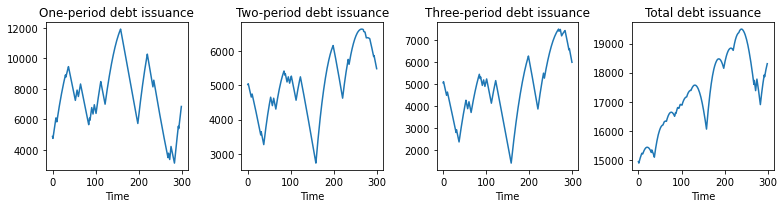

In [8]:
# Plots of different maturities debt issuance

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(11, 3))
ax1.plot(u[0, :])
ax1.set_title('One-period debt issuance')
ax1.set_xlabel('Time')
ax2.plot(u[1, :])
ax2.set_title('Two-period debt issuance')
ax2.set_xlabel('Time')
ax3.plot(u[2, :])
ax3.set_title('Three-period debt issuance')
ax3.set_xlabel('Time')
ax4.plot(u[0, :] + u[1, :] + u[2, :])
ax4.set_title('Total debt issuance')
ax4.set_xlabel('Time')
plt.tight_layout()
plt.show()

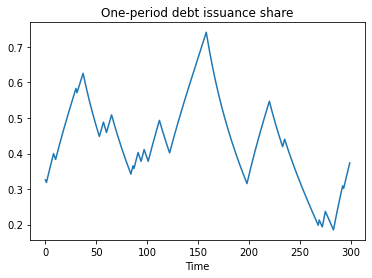

In [9]:
# Plot share of debt issuance that is short-term

fig, ax = plt.subplots()
ax.plot((u[0, :] / (u[0, :] + u[1, :] + u[2, :])))
ax.set_title('One-period debt issuance share')
ax.set_xlabel('Time')
plt.show()